In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL 
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
m = 5
N_particles = m**2
spacing = 2
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.orientation = orientation[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Squares']


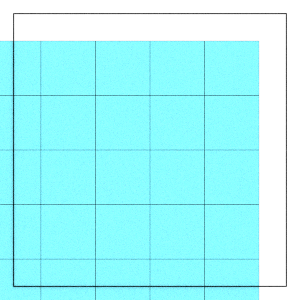

In [4]:
render(frame)

In [5]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v3.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v3.gsd', mode='x') as f:
    f.append(frame)

In [6]:
cpu = hoomd.device.CPU()

Flow 

- Have a compressed system 
- Set betaP to 1 inititially 
- Simulation:
    - Record Volume fraction for each timestep 
    - Pressure should remain constant 
    - Only run simulation until the volume fraction stabilizes within a reasonable error 
    - Take average of volume fraction at the last few timesteps after the simulation stabilizes (after transition state)
- Increase betaP by 1
- Repeat Simulation process and store the constant Pressure and volume fraction with the error after average of last few is taken
- Repeat until target volume fraction is reached

In [105]:
def expand(simulation, initial_betaP, weight, target_vf, s, run_steps, delta, log_interval=100, stabilization_threshold=1e10-1, avg_steps=1000):
    simulation.create_state_from_gsd(filename='lattice_sq_v3.gsd')

    fn = os.path.join(os.getcwd(), 'trajectory_expansion_v3.gsd')
    ![ -e "$fn" ] && rm "$fn"

    gsd_writer = hoomd.write.GSD(
        filename='trajectory_expansion_v3.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
    )
    simulation.operations.writers.append(gsd_writer)

    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = s ** 2
    current_betaP = initial_betaP
    results = []

    while True:
        # Set up BoxMC with the current betaP
        boxmc = hoomd.hpmc.update.BoxMC(
            trigger=hoomd.trigger.Periodic(10),
            betaP=current_betaP
        )

        boxmc.volume = dict(
            mode='standard',
            weight=0.75,
            delta=-0.5
        )


        simulation.operations.updaters.append(boxmc)

        volume_fractions = []
        pressures = []
        stable = False

        # Run the simulation until volume fraction stabilizes
        for step in range(0, run_steps, log_interval):
            simulation.run(log_interval)

            current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
            volume_fractions.append(current_vf)
            pressures.append(current_betaP)

            if len(volume_fractions) > avg_steps // log_interval:
                recent_vfs = volume_fractions[-(avg_steps // log_interval):]
                vf_mean = numpy.mean(recent_vfs)
                vf_std = numpy.std(recent_vfs)

                # Check stabilization threshold
                if vf_std / vf_mean < stabilization_threshold:
                    stable = True
                    break

        # Compute the average and error after stabilization
        if stable:
            avg_vf = numpy.mean(recent_vfs)
            vf_error = vf_std
            results.append((current_betaP, avg_vf, vf_error))

            # Only print if current_betaP is divisible by 2
            if current_betaP % 1 == 0:
                if len(results) == 1:
                    print(f"{'betaP':<6} | {'Avg VF':<12} | {'Error':<12}")
                    print("-" * 40)

                # Print the current result
                print(f"{current_betaP:<6} | {avg_vf:<12.4f} | {vf_error:<12.4f}")

            # Stop if target volume fraction is reached
            if avg_vf <= target_vf:
                break

            # Increment betaP for the next iteration
            if current_betaP > (1) :
                current_betaP -= 0.5
            else:
                break

        else:
            print("Failed to stabilize within given steps. Consider increasing run_steps or adjusting parameters.")
            break
    
    gsd_writer.flush()

    return results


In [106]:
simulation = hoomd.Simulation(device=cpu, seed=17)

results = expand(initial_betaP=50, weight=3, delta=-5, target_vf=0.5, s=2, run_steps=30_00000, simulation=simulation)

betaP  | Avg VF       | Error       
----------------------------------------
50     | 0.9997       | 0.0003      
49.0   | 0.9984       | 0.0005      
48.0   | 0.9955       | 0.0004      
47.0   | 0.9918       | 0.0021      
46.0   | 0.9803       | 0.0045      
45.0   | 0.9762       | 0.0003      
44.0   | 0.9692       | 0.0036      
43.0   | 0.9604       | 0.0011      
42.0   | 0.9538       | 0.0017      
41.0   | 0.9560       | 0.0031      
40.0   | 0.9536       | 0.0027      
39.0   | 0.9500       | 0.0074      
38.0   | 0.9379       | 0.0063      
37.0   | 0.9222       | 0.0041      
36.0   | 0.9173       | 0.0066      
35.0   | 0.9400       | 0.0036      
34.0   | 0.9419       | 0.0009      
33.0   | 0.9386       | 0.0045      
32.0   | 0.9310       | 0.0082      
31.0   | 0.9056       | 0.0053      
30.0   | 0.9199       | 0.0047      
29.0   | 0.9164       | 0.0141      
28.0   | 0.9029       | 0.0055      
27.0   | 0.9265       | 0.0031      
26.0   | 0.9053       | 0.0028    

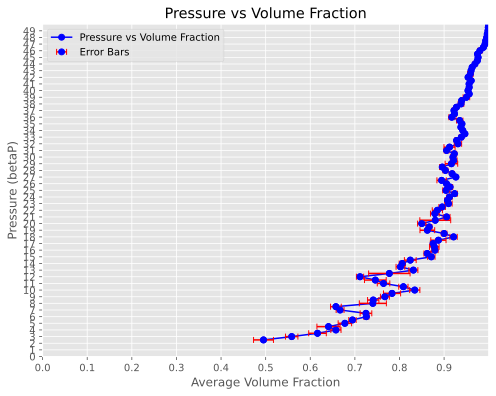

In [107]:
# Extract the betaP and avg_vf values
betaP_values = [result[0] for result in results]
avg_vf_values = [result[1] for result in results]

# Create the plot with volume fraction on the x-axis and pressure on the y-axis
plt.figure(figsize=(8, 6))
plt.plot(avg_vf_values, betaP_values, marker='o', linestyle='-', color='b', label='Pressure vs Volume Fraction')

# Add labels and title
plt.xlabel('Average Volume Fraction')
plt.ylabel('Pressure (betaP)')
plt.title('Pressure vs Volume Fraction')

# Optional: Add error bars if needed
vf_errors = [result[2] for result in results]
plt.errorbar(avg_vf_values, betaP_values, xerr=vf_errors, fmt='o', color='b', ecolor='r', capsize=3, label='Error Bars')

plt.xlim(0, 1.0)
plt.ylim(0,50)
plt.xticks(numpy.arange(0, 1.0, 0.1))
plt.yticks(numpy.arange(0, 50, 1))

# Display the plot
plt.legend()
plt.grid(True)
plt.show()


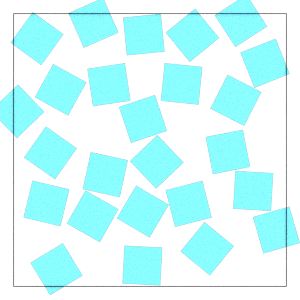

In [108]:
render(simulation.state.get_snapshot())

In [73]:
import hoomd
import numpy as np
import matplotlib.pyplot as plt

def expand1(initial_betaP, weight, run_steps, log_interval=100):
    simulation = hoomd.Simulation(device=cpu, seed=17)
    simulation.create_state_from_gsd(filename='lattice_sq_v3.gsd')

    fn = os.path.join(os.getcwd(), 'trajectory_expansion_v3.gsd')
    ![ -e "$fn" ] && rm "$fn"

    gsd_writer = hoomd.write.GSD(
        filename='trajectory_expansion_v3.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
    )
    simulation.operations.writers.append(gsd_writer)
    
    # Set up the integrator and shape for squares
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    # Define volume of a square particle
    s = 2  # Assuming the side length of the square is 2 units
    volume_particle = s ** 2

    # Set current betaP
    current_betaP = initial_betaP

    # Set up BoxMC with the current betaP
    boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(10),
        betaP=current_betaP
    )

    boxmc.volume = dict(
        mode='standard',
        weight=weight,
        delta=-1
    )

    boxmc.length = dict(
        weight=0.5,
        delta=(0.05, 0.05, 0)
    )

    # Add BoxMC updater to the simulation
    simulation.operations.updaters.append(boxmc)

    # Prepare for simulation and data collection
    volume_fractions = []
    pressures = []

    # Run the simulation for a single betaP and log volume fractions
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)

        # Calculate the volume fraction at this step
        current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
        volume_fractions.append(current_vf)
        pressures.append(current_betaP)

        # Optionally check stabilization, but not required for this version
        # if len(volume_fractions) > avg_steps // log_interval:
        #     recent_vfs = volume_fractions[-(avg_steps // log_interval):]
        #     vf_mean = np.mean(recent_vfs)
        #     vf_std = np.std(recent_vfs)
        #     if vf_std / vf_mean < stabilization_threshold:
        #         break

    # Plot the volume fraction vs. steps
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(0, run_steps, log_interval), volume_fractions, label="Volume Fraction")
    plt.xlabel("Steps")
    plt.ylabel("Volume Fraction")
    plt.title(f"Volume Fraction vs Steps for betaP = {current_betaP}")
    plt.grid(True)
    plt.show()

    return volume_fractions, pressures


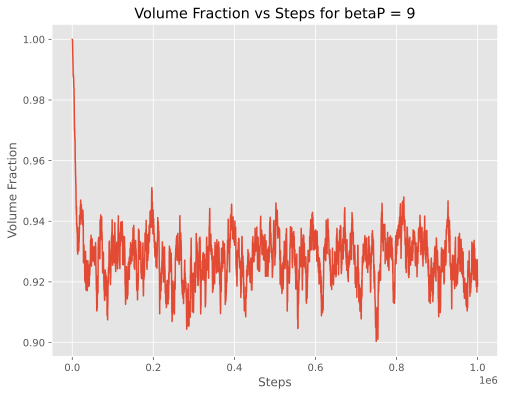

([1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.999849540992289,
  0.9995390846031554,
  0.998778896958899,
  0.998778896958899,
  0.9974384869615719,
  0.9974384869615719,
  0.9945872169020753,
  0.9945872169020753,
  0.9945872169020753,
  0.9945872169020753,
  0.9945716855251552,
  0.9900251847186676,
  0.9900251847186676,
  0.9899275928428916,
  0.9899275928428916,
  0.9899275928428916,
  0.9899275928428916,
  0.9893759417789002,
  0.9877071974288129,
  0.9877071974288129,
  0.9885427538036686,
  0.9885427538036686,
  0.9885359447694858,
  0.9875509169928557,
  0.9876820357735283,
  0.9876820357735283,
  0.9876820357735283,
  0.9876820357735283,
  0.9876820357735283,
  0.9864096646015832,
  0.985507431291061,
  0.9852218851972382,
  0.9842974150105069,
  0.9842974150105069,
  0.9842974150105069,
  0.9842974150105069,
  0.9840862916602995,
  0.9838392058463747,
  0.9838392058463747,
  0.9826820049147066,
  0.982248643282742,
  0.9813881020047261,
  0.9813881020047261,
  0.9795337487910069,
  

In [74]:
expand1(initial_betaP=9, weight=0.5, run_steps=10_00000)